# Architecting ML on AWS Notebooks
## Module 2: Local Data Engineering on Bike Sharing Dataset

`(Revision History:
PA1, 2020-04-14, @akirmak: Initial version. Extended work of (ChandraLingam's AmazonSageMakerCourse in Udemy (https://github.com/ChandraLingam/AmazonSageMakerCourse and few other Open Source Notebooks published for Bike Rental Demand Competition) 
`

## Overview 
This notebook explains how we can go about explore and prepare data for model building. The notebook is structured in the following way 

 - About Dataset
 - Data Summary
 - Feature Engineering
 - Missing Value Analysis
 - Outlier Analysis
 - Correlation Analysis
 - Visualizing Distribution Of Data

## Use Case



## DataSet
### Overview
Open an account & download the dataset from Kaggle: https://www.kaggle.com/c/bike-sharing-demand
(In this lab, the dataset is already included in the repo)

Quote Kaggle: 

"Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C."

### Data Fields

Dependent Variables:
* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed

Independent Variables:
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals (Dependent Variable)

## Setup

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
#import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Get the Data

In [2]:
df = pd.read_csv('data/bikesharing/train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('data/bikesharing/test.csv', parse_dates=['datetime'])

In [3]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [4]:
df_test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [5]:
# We need to convert datetime to numeric for training.
# Let's extract key features into separate numeric columns
def hba_add_extended_date_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['hour'] = df['datetime'].dt.hour

In [6]:
hba_add_extended_date_features(df)
hba_add_extended_date_features(df_test)

In [7]:
df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
year                   int64
month                  int64
day                    int64
dayofweek              int64
hour                   int64
dtype: object

In [8]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2


In [9]:
columns = ['count', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek','hour']

In [10]:
# Correlation will indicate how strongly features are related to the output
df.corr()['count']

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
casual        0.690414
registered    0.970948
count         1.000000
year          0.260403
month         0.166862
day           0.019826
dayofweek    -0.002283
hour          0.400601
Name: count, dtype: float64

In [11]:
group_hour = df.groupby(['hour'])
average_by_hour = group_hour['count'].mean()

Text(0.5, 1.0, 'Rental Count Average by hour')

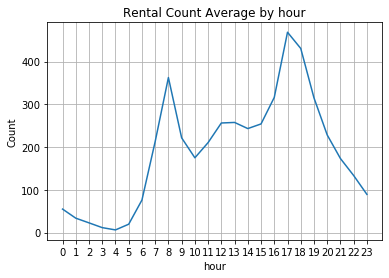

In [12]:
plt.plot(average_by_hour.index,average_by_hour)
plt.xlabel('hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Rental Count Average by hour')

In [13]:
group_year_hour = df.groupby(['year','hour'])

In [14]:
average_year_hour = group_year_hour['count'].mean()

Text(0.5, 1.0, 'Rental Count Average by Year,Hour')

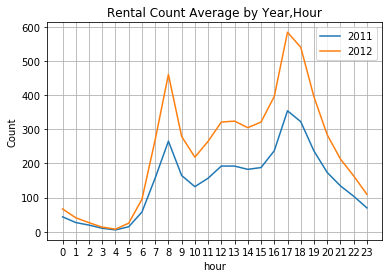

In [15]:
for year in average_year_hour.index.levels[0]:
    #print (year)
    #print(average_year_month[year])
    plt.plot(average_year_hour[year].index,average_year_hour[year],label=year)
    
plt.legend()    
plt.xlabel('hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Rental Count Average by Year,Hour')

In [16]:
group_workingday_hour = df.groupby(['workingday','hour'])

In [17]:
average_workingday_hour = group_workingday_hour['count'].mean()

Text(0.5, 1.0, 'Rental Count Average by Working Day,Hour')

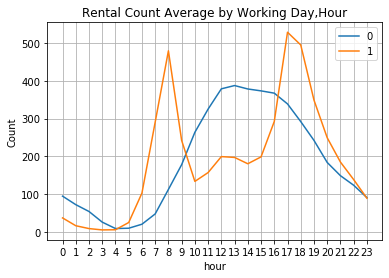

In [18]:
for workingday in average_workingday_hour.index.levels[0]:
    #print (year)
    #print(average_year_month[year])
    plt.plot(average_workingday_hour[workingday].index,average_workingday_hour[workingday],label=workingday)
    
plt.legend()    
plt.xlabel('hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Rental Count Average by Working Day,Hour')

In [19]:
# Save all data
df.to_csv('hba_bike_all.csv',index=False,
          columns=columns)

## Training and Validation Set
### Target Variable as first column followed by input features
### Training, Validation files do not have a column header

In [20]:
# Training = 70% of the data
# Validation = 30% of the data
# Randomize the datset
np.random.seed(5)
l = list(df.index)
np.random.shuffle(l)
df = df.iloc[l]

rows = df.shape[0]
train = int(.7 * rows)
test = int(.3 * rows)

rows, train, test

(10886, 7620, 3265)

In [21]:
# Write Training Set
df[:train].to_csv('hba_bike_train.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [22]:
# Write Validation Set
df[train:].to_csv('hba_bike_validation.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [23]:
# Test Data has only input features
df_test.to_csv('hba_bike_test.csv',index=False)

In [24]:
columns
','.join(columns)

'count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour'

In [25]:
# Write Column List
with open('hba_bike_train_column_list.txt','w') as f:
    f.write(','.join(columns))

### Feature Engineering (Part I) (Done on ALL of the training + validation data)
In addition to existing independent variables, we will create new variables to improve the prediction power of model. Here, we generated new variables like hour, month, day and year.

In [26]:
dailyData = df


In [27]:
dailyData.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
3650,2011-09-03 00:00:00,3,0,0,2,26.24,30.305,73,7.0015,22,65,87,2011,9,3,5,0
8909,2012-08-13 14:00:00,3,0,1,1,32.80,34.850,33,7.0015,85,163,248,2012,8,13,0,14
4623,2011-11-05 17:00:00,4,0,0,1,15.58,19.695,40,11.0014,100,234,334,2011,11,5,5,17


In [28]:
#dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
#dailyData["year"] = dailyData.datetime.apply(lambda x : x.split()[0].split("-")[0])
#dailyData["month"] = dailyData.datetime.apply(lambda x : x.split()[0].split("-")[1])
#dailyData["day"] = dailyData.datetime.apply(lambda x : x.split()[0].split("-")[2])
#dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])

#dailyData["weekday_name"] = dailyData.datetime.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["season_name"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather_name"] = dailyData.weather.map({1: "Clear",\
                                        2 : "Cloudy", \
                                        3 : "Rainy", \
                                        4 : "Extreme" })


In [29]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour,season_name,weather_name
3650,2011-09-03 00:00:00,3,0,0,2,26.24,30.305,73,7.0015,22,65,87,2011,9,3,5,0,Fall,Cloudy
8909,2012-08-13 14:00:00,3,0,1,1,32.80,34.850,33,7.0015,85,163,248,2012,8,13,0,14,Fall,Clear
4623,2011-11-05 17:00:00,4,0,0,1,15.58,19.695,40,11.0014,100,234,334,2011,11,5,5,17,Winter,Clear
8818,2012-08-09 19:00:00,3,0,1,1,32.80,37.880,55,12.9980,90,533,623,2012,8,9,3,19,Fall,Clear
1640,2011-04-14 06:00:00,2,0,1,1,13.94,17.425,76,7.0015,4,66,70,2011,4,14,3,6,Summer,Clear


In [30]:
dailyData.shape


(10886, 19)

In [31]:
dailyData.dtypes

datetime        datetime64[ns]
season                   int64
holiday                  int64
workingday               int64
weather                  int64
temp                   float64
atemp                  float64
humidity                 int64
windspeed              float64
casual                   int64
registered               int64
count                    int64
year                     int64
month                    int64
day                      int64
dayofweek                int64
hour                     int64
season_name             object
weather_name            object
dtype: object

## Explore the Data
Explore to get a fair understanding of the data set.

### Outliers Analysis

At first look, "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).But in addition to that, following inferences can also been made from the simple boxplots given below.

 - Spring season has got relatively lower count.The dip in median value
   in boxplot gives evidence for it.
 - The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time. 
 - Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from from figure 4.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Weather'),
 Text(0.5, 1.0, 'Count Across Weather')]

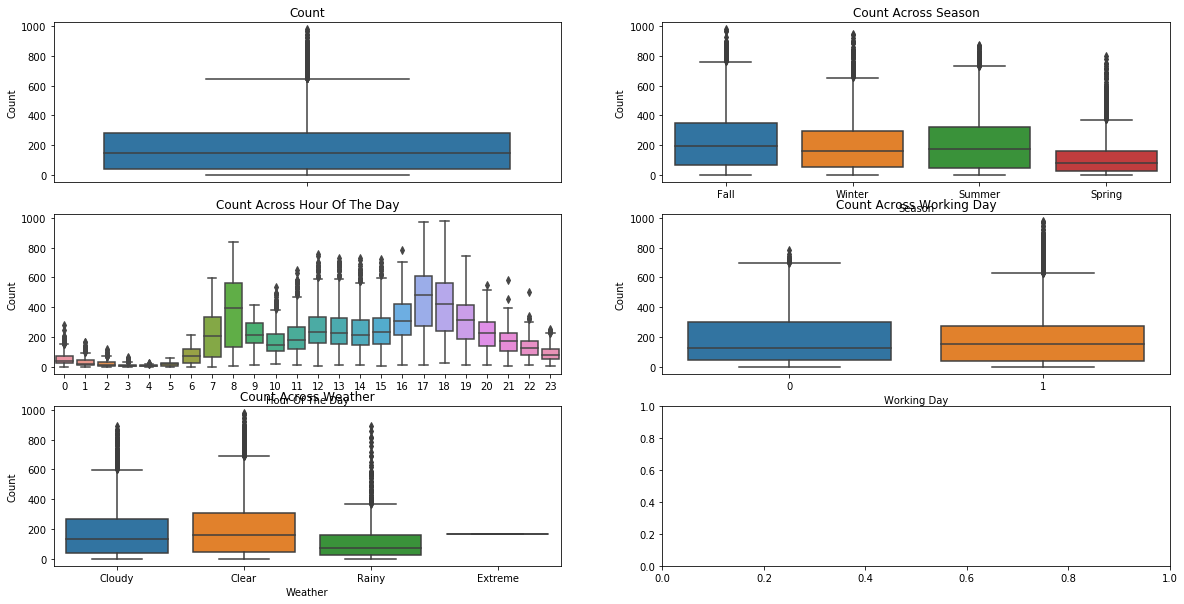

In [32]:


fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(20, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season_name",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])
sn.boxplot(data=dailyData,y="count",x="weather_name",orient="v",ax=axes[2][0])

axes[0][0].set(ylabel='Count',title="Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Count Across Working Day")
axes[2][0].set(xlabel='Weather', ylabel='Count',title="Count Across Weather")


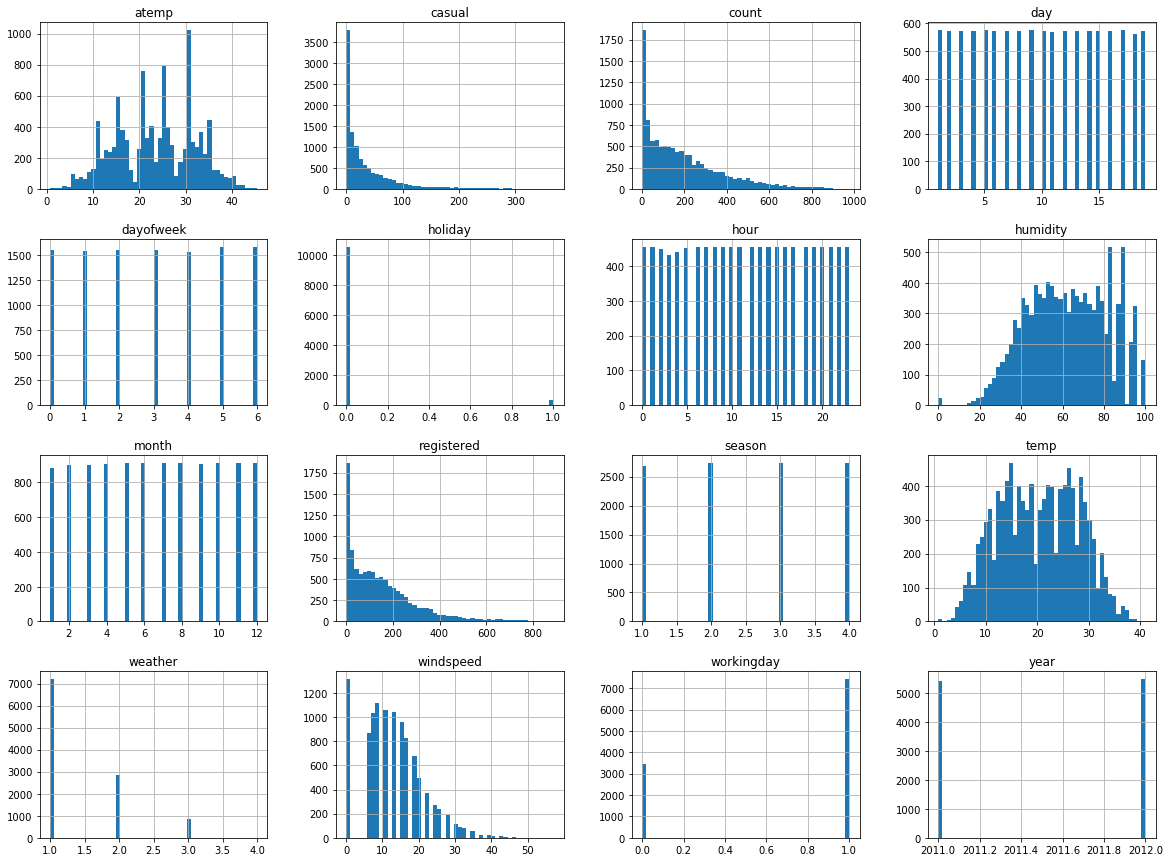

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
dailyData.hist(bins=50, figsize=(20,15))
plt.show()


## Correlation Analysis

One common to understand how a dependent variable is influenced by features (numerical) is to fibd a correlation matrix between them. Lets plot a correlation plot between "count" and ["temp","atemp","humidity","windspeed"].

 - temp and humidity features has got positive and negative correlation
   with count respectively.Although the correlation between them are not
   very prominent still the count variable has got little dependency on
   "temp" and "humidity".
 - windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
 - "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
 - "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.

Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".

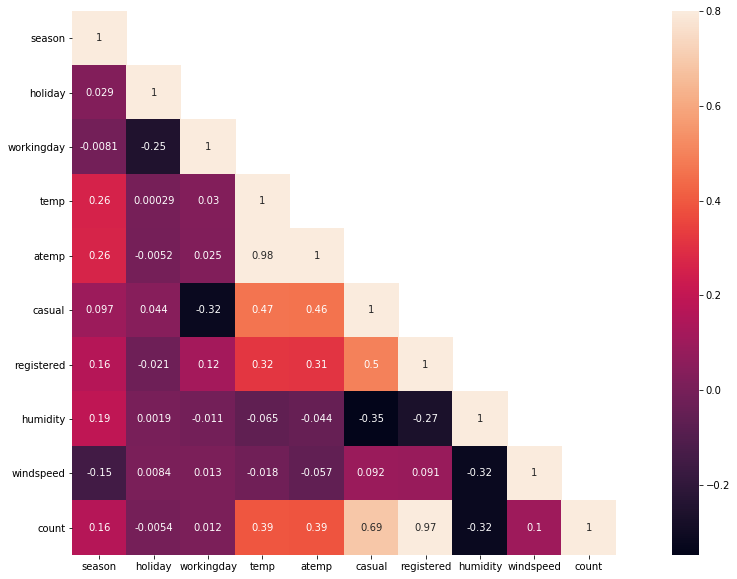

In [34]:
corrMatt = dailyData[["season", "holiday", "workingday", "temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

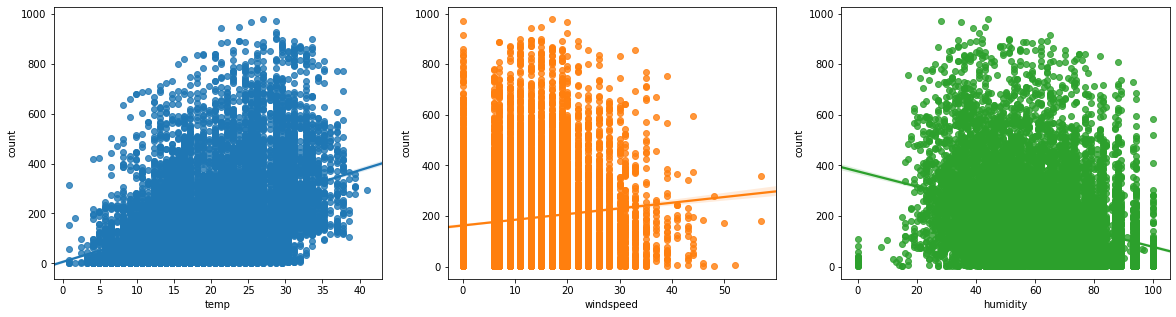

In [35]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(20, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

## Hypothesis Testing (Trends based on Hour, Weekday,Usertype etc.)

 - It is quiet obvious that people tend to rent bike during summer
   season since it is really conducive to ride bike at that
   season.Therefore June, July and August has got relatively higher
   demand for bicycle.
 - On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
 - Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
 - The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

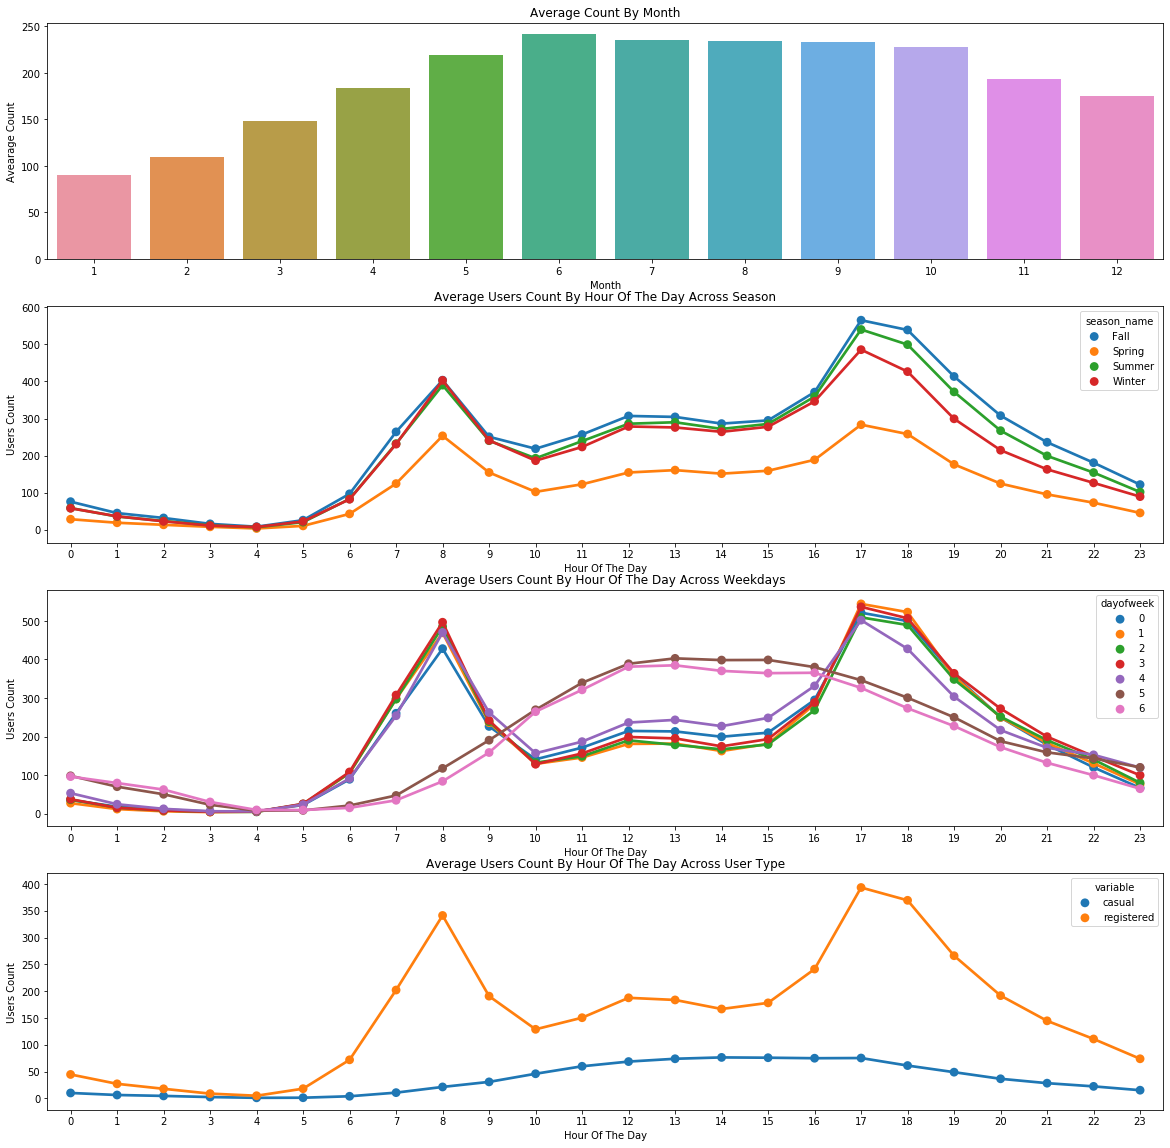

In [36]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
#hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
#sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season_name"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season_name"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","dayofweek"],sort=True)["count"].mean()).reset_index()
#sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["day"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
#sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["dayofweek"],hue_order=hueOrder,data=hourAggregated, join=True,ax=ax3)
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["dayofweek"],data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

# count by years - fix this
# yearTransformed = pd.melt(dailyData[["month","year"]], id_vars=['month'], value_vars=["2011", "2012"])
#yearAggregated = pd.DataFrame(yearTransformed.groupby(["year","variable"],sort=True)["value"].mean()).reset_index()
#sn.pointplot(x=yearAggregated["month"], y=yearAggregated["value"],hue=yearAggregated["variable"],hue_order=["2011","2012"], data=yearAggregated, join=True,ax=ax5)
#ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Year",label='Year')



### Log Transformations

As we know that dependent variables have natural outliers so we will predict log of dependent variables. Log Transformations. The log transformation can be used to make highly skewed distributions less skewed. This can be valuable both for making patterns in the data more interpretable and for helping to meet the assumptions of inferential statistics.

In [37]:
hbay_trans = np.log1p(dailyData["casual"])

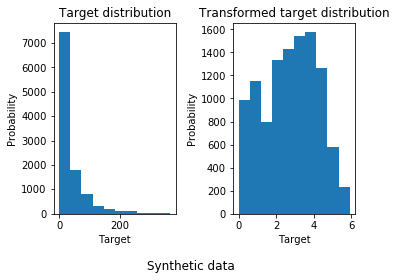

In [38]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(dailyData["casual"], bins=10)
#ax0.set_xlim([0, 500])
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(hbay_trans, bins=10)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

## Feature Engineering II
In addition to existing independent variables, we will create new variables to improve the prediction power of model. 
Here we will create more variables, let’s look at the some of these:

weekend, day type, bin based on temperature/hour/year. 

In [39]:
# to be replaced by decision tree regressor partitioning
#def hba_hour_bin(hr):
#    if hr<8:
#        return 1
#    elif hr>=22:
#        return 2
#    elif hr>9 & hr<18:
#        return 3
#    elif hr==8:
#        return 4
#    elif hr==9:
#        return 5
#    elif hr==20 | hr==21:
#        return 6
#    elif hr==19 | hr==18:
#        return 7


In [40]:
# Hour bins

# dailyData["day_part"].apply(hba_hour_bin(dailyData["hour"]))

#dailyData["day_part"] = np.where(dailyData["hour"] < 8,1,0)
#dailyData["day_part"] = np.where(dailyData["hour"] >= 22,2,0)




In [41]:
# Weekend: Created a separate variable for weekend (0/1)
dailyData["weekend"] = 0

dailyData.loc[dailyData['dayofweek'] == 5  , 'weekend'] = 1 # saturday
dailyData.loc[dailyData['dayofweek'] == 6, 'weekend'] = 1

In [42]:
# Year: Created a separate variable for every Q
dailyData["quarter"] = 0

# dailyData.loc[dailyData['year'] == 2011  , 'year_part'] = 1
dailyData.loc[dailyData['month'] == 1  , 'quarter'] = 1
dailyData.loc[dailyData['month'] == 2  , 'quarter'] = 1
dailyData.loc[dailyData['month'] == 3  , 'quarter'] = 1
dailyData.loc[dailyData['month'] == 4  , 'quarter'] = 2
dailyData.loc[dailyData['month'] == 5  , 'quarter'] = 2
dailyData.loc[dailyData['month'] == 6  , 'quarter'] = 2
dailyData.loc[dailyData['month'] == 7  , 'quarter'] = 3
dailyData.loc[dailyData['month'] == 8  , 'quarter'] = 3
dailyData.loc[dailyData['month'] == 9  , 'quarter'] = 3
dailyData.loc[dailyData['month'] == 10  , 'quarter'] = 4
dailyData.loc[dailyData['month'] == 11  , 'quarter'] = 4
dailyData.loc[dailyData['month'] == 12  , 'quarter'] = 4

#dailyData['quarter'] = np.where(dailyData['month']==1 , 2, 1)
#dailyData.loc[(dailyData['year'] == 2011).bool() & (dailyData['year'] == 2011).bool() , 'year_part'] = 1

In [43]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,year,month,day,dayofweek,hour,season_name,weather_name,weekend,quarter
3650,2011-09-03 00:00:00,3,0,0,2,26.24,30.305,73,7.0015,22,...,87,2011,9,3,5,0,Fall,Cloudy,1,3
8909,2012-08-13 14:00:00,3,0,1,1,32.80,34.850,33,7.0015,85,...,248,2012,8,13,0,14,Fall,Clear,0,3
4623,2011-11-05 17:00:00,4,0,0,1,15.58,19.695,40,11.0014,100,...,334,2011,11,5,5,17,Winter,Clear,1,4
8818,2012-08-09 19:00:00,3,0,1,1,32.80,37.880,55,12.9980,90,...,623,2012,8,9,3,19,Fall,Clear,0,3
1640,2011-04-14 06:00:00,2,0,1,1,13.94,17.425,76,7.0015,4,...,70,2011,4,14,3,6,Summer,Clear,0,2


## Resampling (aggregations etc.) via changing index on a separate data frame (original intact)

In [44]:
ospd = dailyData
ospd["idx_date"] = dailyData["datetime"]
ospd = ospd.set_index('idx_date')
ospd.index = pd.to_datetime(ospd.index)

ospd.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,year,month,day,dayofweek,hour,season_name,weather_name,weekend,quarter
idx_date,,,,,,,,,,,,,,,,,,,,,
2011-09-03,2011-09-03,3,0,0,2,26.24,30.305,73,7.0015,22,...,87,2011,9,3,5,0,Fall,Cloudy,1,3


In [45]:
ospd.tail(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,year,month,day,dayofweek,hour,season_name,weather_name,weekend,quarter
idx_date,,,,,,,,,,,,,,,,,,,,,
2011-07-10 09:00:00,2011-07-10 09:00:00,3,0,0,1,30.34,34.85,66,6.0032,62,...,169,2011,7,10,6,9,Fall,Clear,1,3


In [46]:
# Display a random sampling of 5 rows
ospd.sample(5, random_state=0)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,year,month,day,dayofweek,hour,season_name,weather_name,weekend,quarter
idx_date,,,,,,,,,,,,,,,,,,,,,
2012-09-12 02:00:00,2012-09-12 02:00:00,3,0,1,1,21.32,25.000,72,6.0032,2,...,11,2012,9,12,2,2,Fall,Clear,0,3
2012-06-03 05:00:00,2012-06-03 05:00:00,2,0,0,1,20.50,24.240,68,0.0000,1,...,12,2012,6,3,6,5,Summer,Clear,1,2
2012-04-07 15:00:00,2012-04-07 15:00:00,2,0,0,1,21.32,25.000,19,27.9993,321,...,626,2012,4,7,5,15,Summer,Clear,1,2
2011-01-06 00:00:00,2011-01-06 00:00:00,1,0,1,1,7.38,12.120,55,0.0000,0,...,11,2011,1,6,3,0,Spring,Clear,0,1
2012-04-05 06:00:00,2012-04-05 06:00:00,2,0,1,1,14.76,16.665,46,22.0028,8,...,126,2012,4,5,3,6,Summer,Clear,0,2


In [47]:
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

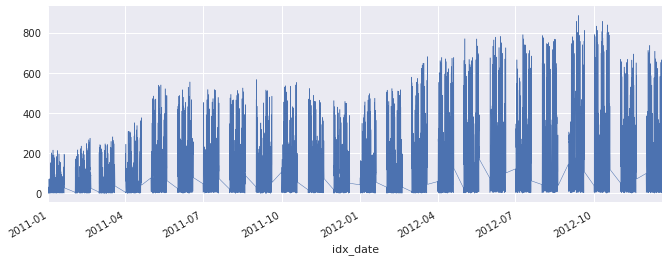

In [48]:
ospd['registered'].plot(linewidth=0.5);


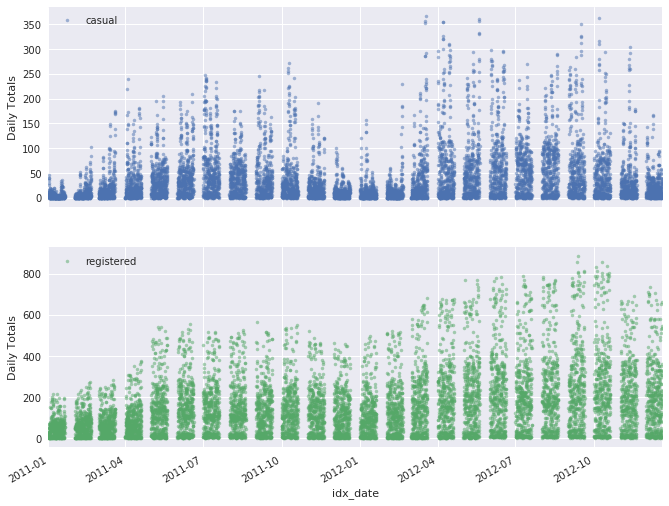

In [49]:
cols_plot = ['casual', 'registered']
axes = ospd[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
  ax.set_ylabel('Daily Totals')

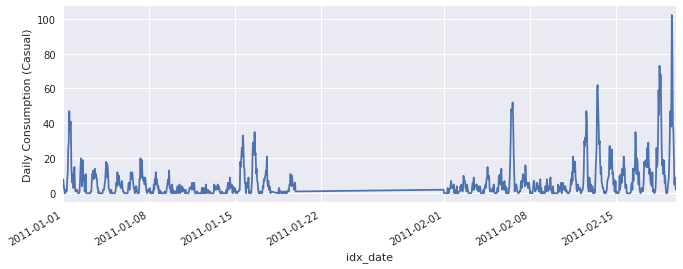

In [50]:
ax = ospd.loc['2011-01':'2011-02', 'casual'].plot()
ax.set_ylabel('Daily Consumption (Casual)');

In [51]:
ospd['casual+registered'] = ospd['casual'] + ospd['registered']

### Resampling

We can see that the weekly mean time series is smoother than the daily time series because higher frequency variability has been averaged out in the resampling.

In [52]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
ospd_data_columns = ['casual', 'registered', 'casual+registered']
# Resample to weekly frequency, aggregating with mean
opsd_weekly_mean = ospd[ospd_data_columns].resample('W').mean()
opsd_weekly_mean.head(3)

,casual,registered,casual+registered
idx_date,,,
2011-01-02,9.829787,28.170213,38.000000
2011-01-09,4.123457,53.950617,58.074074
2011-01-16,4.134969,51.233129,55.368098


In [53]:
# Compute the monthly sums, setting the value to NaN for any month which has
# fewer than 28 days of data
ospd_monthly = ospd[ospd_data_columns].resample('M').sum(min_count=28)
ospd_monthly.head(3)

,casual,registered,casual+registered
idx_date,,,
2011-01-31,2008,21544,23552
2011-02-28,3776,29068,32844
2011-03-31,7910,30825,38735


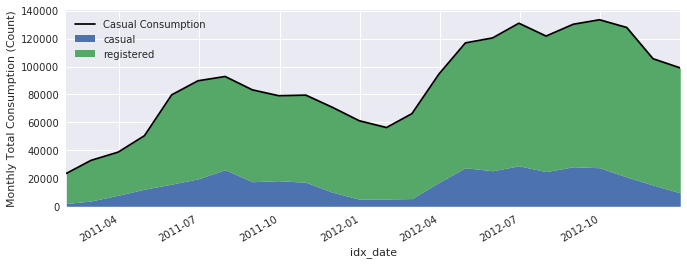

In [55]:
fig, ax = plt.subplots()
ax.plot(ospd_monthly['casual+registered'], color='black', label='Casual Consumption')
ospd_monthly[['casual', 'registered']].plot.area(ax=ax, linewidth=0)
# ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.legend()
ax.set_ylabel('Monthly Total Consumption (Count)');

In [57]:
# DO NOT Drop resampled fields before training (since original training DF kept intact)
#ospd.drop("day_part", axis=1, inplace=True) 
#ospd.drop("casual+registered", axis=1, inplace=True) 

ospd.sample(3, random_state=0)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,year,month,day,dayofweek,hour,season_name,weather_name,weekend,quarter,casual+registered
idx_date,,,,,,,,,,,,,,,,,,,,,
2012-09-12 02:00:00,2012-09-12 02:00:00,3,0,1,1,21.32,25.00,72,6.0032,2,...,2012,9,12,2,2,Fall,Clear,0,3,11
2012-06-03 05:00:00,2012-06-03 05:00:00,2,0,0,1,20.50,24.24,68,0.0000,1,...,2012,6,3,6,5,Summer,Clear,1,2,12
2012-04-07 15:00:00,2012-04-07 15:00:00,2,0,0,1,21.32,25.00,19,27.9993,321,...,2012,4,7,5,15,Summer,Clear,1,2,626


In [58]:
#df_validation.head()
dailyData.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,year,month,day,dayofweek,hour,season_name,weather_name,weekend,quarter,idx_date
3650,2011-09-03 00:00:00,3,0,0,2,26.24,30.305,73,7.0015,22,...,2011,9,3,5,0,Fall,Cloudy,1,3,2011-09-03 00:00:00
8909,2012-08-13 14:00:00,3,0,1,1,32.80,34.850,33,7.0015,85,...,2012,8,13,0,14,Fall,Clear,0,3,2012-08-13 14:00:00
4623,2011-11-05 17:00:00,4,0,0,1,15.58,19.695,40,11.0014,100,...,2011,11,5,5,17,Winter,Clear,1,4,2011-11-05 17:00:00


## Storing Useful Variables
Before exiting this notebook, run the following cells to save some variables for later use.



In [59]:
%store df
%store dailyData

%store df_test
%store columns

Stored 'df' (DataFrame)
Stored 'dailyData' (DataFrame)
Stored 'df_test' (DataFrame)
Stored 'columns' (list)


## Congratulations. 
TBD